In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import pandas as pd
%matplotlib inline

### Brief Overview

This assignment is designed to help you practice with generative models and simulation techniques. You will receive various pieces of information that will guide you through solving a problem in a step-by-step manner. After completing the initial analysis, you will be asked to apply what you have learned to a different question.


1. You're limited to using the following Python modules: `matplotlib`, `numpy`, `scipy`, and `pandas`. No other modules are accepted.

2. When creating graphs, make sure each one has a title and labels for both axes. You can adjust the size of your plots by using `plt.figure(figsize=(width, height))`, where `width` and `height` are the dimensions of the plot you want.



Model Revenue for Membership-based Training Website in 2022

- Overview: Calculate sales revenue for a website that charges a $39.99 monthly membership fee. Users can take any amount of time to complete their training and can leave the platform anytime.

Key Points:
- Women tend to complete training faster and quit less often than men.
- The likelihood of a student quitting decreases the longer they are enrolled.
- Membership has grown by an average of 13\% yearly over the last five years, with a 1.4\% standard deviation. In 2021, 90,316 people enrolled.

* Data Source:
- Access historical data from `memberships_info.csv` available at [URL](https://www.dropbox.com/s/evaaiu1mevw6t3j/memberships_info.csv?dl=1).

Data Details:

| Column       | Description                                   |
|--------------|-----------------------------------------------|
| member_id    | Unique member identifier                      |
| gender       | Gender: M (male) or F (female)                |
| status       | Membership status: C (completed) or Q (quit)  |
| mem_duration | Membership length in months                   |

Below, you will create a generative model to estimate next year's revenue by determining the model's parameters and hypothesizing their distributions for estimation.


### Reading the Data

- Load the dataset using pandas and store it in a variable named `sample_users`.
- Calculate the percentage of males who have completed the training in the dataset.


In [2]:
# Write your code here
sample_users = pd.read_csv('https://www.dropbox.com/s/evaaiu1mevw6t3j/memberships_info.csv?dl=1');

completed_training_males = sample_users[(sample_users['gender'] == 'M') & (sample_users['status'] == 'C')]
num_completed_training_males = completed_training_males.shape[0]
total_males = sample_users[sample_users['gender'] == 'M'].shape[0]

percentage_completed_training_males = (num_completed_training_males / total_males) * 100
percentage_completed_training_males

60.27584036918559

### Generative Model for our Simulations

Below is an explanation of the model we will use to figure out yearly sales. The model works in 4 steps:

1. Guess the number of new (future) members using a  $\mu=13$ and $\sigma =1.4$ i from last year, 2021.

2. For each new member, decide if they will:

  2.1 Leave the training: If so, sample the the number of months they stay before leaving.
      
  2.2 Finish the training: If so, sample the the number of months they stay until they finish.

3. Compute the revenue from memberships based on the total number of months of enrollment simulated for each member.

* Look at the picture below to understand this better.


<img src="https://www.dropbox.com/s/xvvof9g36m7pthq/generative_model_diagram.png?dl=1" alt="drawing" style="width:700px;"/>

In [3]:
from scipy.stats import norm


In [4]:
d = norm(0,0.005)
d.pdf(0) * 0.0001

0.007978845608028654

### Estimating the 95% Confidence Interval from Simulations

- The goal is not to identify a single value but to determine the range where the revenue is likely to be found 95% of the time. To achieve this, repeat the simulation 5,000 times to calculate the 95% confidence interval for the revenue.


###  1. Generating the Number of Enrollees

- The training company anticipates a growth rate in enrollments for 2022 similar to previous years, with an expected mean growth rate of 13% (μ=13%) and a standard deviation of 1.4% (σ=1.4%).
- Given the enrollment figure of 90,316 from the previous year, calculate the projected number of enrollments for 2022 using the normal distribution. This projection will serve as a single data point in the generative model.
- Store the projected enrollment number in a variable named `nb_enrollees`. Make sure you convert this number to an integer, as the normal distribution will generate a continuous value.



In [5]:
# Write your code here
np.random.seed(10)

# Mean growth rate 13%, Standard deviation 1.4%, Previous enrollment 90316
mu = 0.13
sigma = 0.014
prev = 90316

mgr_samples = np.random.normal(mu, sigma, 1000)

nb_enrollees = np.int32(prev * (1 + mgr_samples.mean()))
nb_enrollees

102038

### Understanding Resampling for Confidence Interval Estimation

- Calculate a 98% confidence interval for the proportion of participants who quit the training program before completion, using the `sample_users` dataset. To estimate a 98% confidence interval for the proportion of participants who quit the training program, we'll use a technique called resampling. This involves randomly selecting the same number of observations from our data as the original dataset, with replacement, and repeating this process 10,000 times. Each iteration calculates the quit proportion anew.

  * To find the quit rate for one instance, divide the number of participants who quit (indicated by `status == "Q"`) by the total number of participants.

- Resampling is beneficial because it allows us to model the variability and estimate the uncertainty of our statistic (in this case, the quit proportion) without needing a larger dataset or making assumptions about the data's distribution.

- The result of these 10,000 resampling iterations will be used to construct the 98% confidence interval, providing a range of values within which the true quit proportion is likely to fall.


In [6]:
# Write your code here
def quit_proportion(data):
    return np.sum(data == 'Q') / data.size

resampled_quit_proportions = []
num_iterations = 200

for _ in range(num_iterations):
    resampled_data = np.random.choice(sample_users['status'], size=sample_users.size, replace=True)
    quit_prop = quit_proportion(resampled_data)
    resampled_quit_proportions.append(quit_prop)

confidence_interval = np.percentile(resampled_quit_proportions, [1, 99])

print("98% Confidence Interval for Proportion of Participants Who Quit:")
print("Lower Bound:", confidence_interval[0])
print("Upper Bound:", confidence_interval[1])

98% Confidence Interval for Proportion of Participants Who Quit:
Lower Bound: 0.35822881186520167
Upper Bound: 0.3616202012901638



### 2. Generating a Radom Quitting Probability

The quitting parameter falls within the 98% confidence interval approximately 98% of the time. To account for this variability in our simulation model, we will select a quitting probability from this interval at random and use it to calculate the estimated number of individuals quitting in each iteration.

- Utilize `np.random.uniform(min, max)` to choose a random value within the specified interval.
- For example, if the quitting probability confidence interval, `quit_prop_conf_int`, ranges from 0.2 to 0.3, a potential value could be:

```python
np.random.uniform(0.2, 0.3)
# Result might be: 0.225
# This can also be written as:
# np.random.uniform(quit_prop_conf_int[0], quit_prop_conf_int[1])
```

Store the selected value in a variable named `quit_prop`.




In [7]:
# Write your code here
quit_prop = np.random.uniform(confidence_interval[0], confidence_interval[1])
quit_prop

0.3612588723310465

### 3. Simulating the Number for People Who Quit and Those Who Complete the Training


- Calculate the number of participants who finish the training and those who quit using `nb_enrollees` and `quit_param`.
- Store the number of finishers in `nb_enrollees_finish` and the number of quitters in `nb_enrollees_quit`.
  - Ensure the output values are integers.
  - Check that the sum of `nb_enrollees_finish` and `nb_enrollees_quit` equals `nb_enrollees`.


In [8]:
# Write your code here
nb_enrollees_finish = np.int32(round(nb_enrollees * (1 - quit_prop)))
nb_enrollees_quit = np.int32(round(nb_enrollees * quit_prop))

assert(nb_enrollees_finish + nb_enrollees_quit == nb_enrollees)

print("Number of participants who finish the training:", nb_enrollees_finish)
print("Number of participants who quit:", nb_enrollees_quit)

Number of participants who finish the training: 65176
Number of participants who quit: 36862


### Determining the Number of Payments Enrollees Make Before Quitting

- Below, we will model the duration of enrollment in months before a participant opts out.

- Note that the likelihood of opting out decreases as participants approach the end of their training:
  - The first month has the highest dropout rate compared to any other month.
  - The dropout probability in month `t` is always greater than in month `t+1`.
  - The more months a participant has remained enrolled, the lower their chance of dropping out.

Illustrations `A`, `B`, and `C` depict examples of the probability distribution within the constraints mentioned, focusing on the range [1, 10].


<img src="https://www.dropbox.com/s/ys12ubh0mvmyji5/decay.png?dl=1" alt="drawing" style="width:1400px;"/>

### Identifying the Most Likely Parameters


- The three figures labeled `A`, `B`, and `C` depict exponential probability distributions. For more details on this distribution, visit: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html

- This distribution, similar to a Gaussian, is characterized by two key parameters:
  - `loc`: Indicates the peak value of the function.
  - `scale`: Defines the rate at which the function's probability declines towards zero. A higher `scale` value means a slower decrease in probability.

- For the cases shown in figures `A`, `B`, and `C`, the `loc` parameter is consistently set to 1, reflecting the highest likelihood of individuals opting out within the first month.
- These figures are differentiated by their `scale` values, with respective decays of `0.2`, `1`, and `200`.

- Below are examples illustrating how to implement the exponential probability distribution (`expon`).



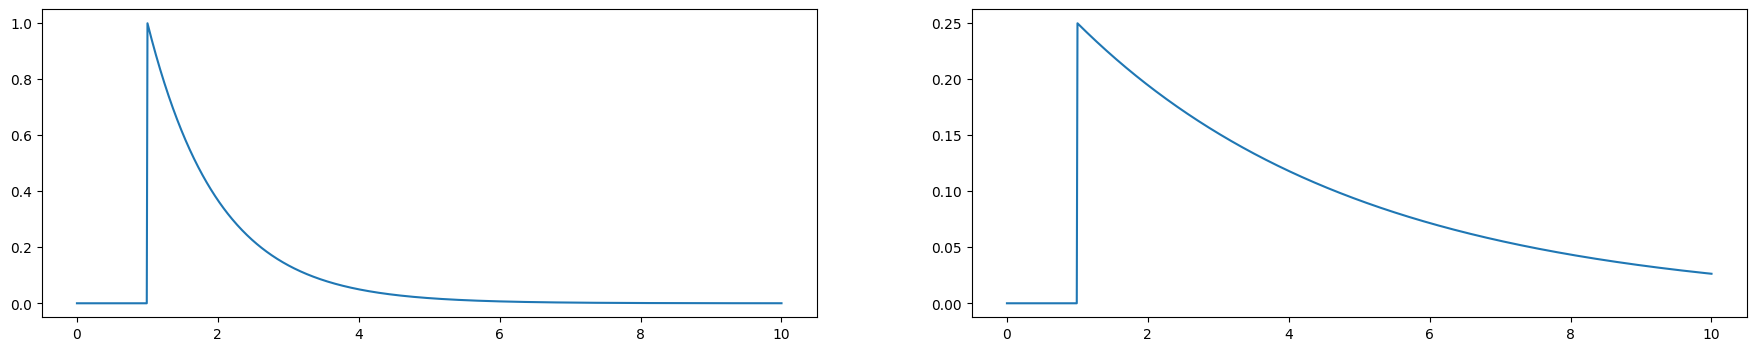

In [81]:
plt.figure(figsize=(22,4))
x = np.linspace(0, 10, 1000)

y_dist_1 = stats.expon(1, 1)
y_dist_2 = stats.expon(1, 4)


plt.subplot(1, 2, 1)
plt.plot(x, y_dist_1.pdf(x), label="$a=0.2$")


plt.subplot(1, 2, 2)
plt.plot(x, y_dist_2.pdf(x), label="$a=1$")



### Maximizing Log-Likelihood with the Scale Parameter

- Determine the `scale` parameter value that results in the highest log-likelihood for our data, assuming `loc=1` to reflect the tendency of enrollees to quit within the first month.

- First, calculate the log-likelihood of the dataset with a `scale` value of 5. Remember, the dataset consists of the duration of membership (`mem_duration`) in months for individuals who have quit (`status=="Q"`).

- Calculate the log-likelihood for the data [2,1,2,3,4] using `location=1` and `scale=5` with the following code:

```python
log_pdfs = stats.expon(1, 5).logpdf([2,1,2,3,4])
sum(log_pdfs)
# Alternatively:
# sum(stats.expon(1, 5).logpdf([2,1,2,3,4]))
```

Note: We create the distribution with `stats.expon(1, 5)` and then use it to compute `logpdf([2,1,2,3,4])`.

In [82]:
# Write your code here


### Estimating Scale Using the Maximum Likelihood


- Calculate and plot the log-likelihood for `scale` values ranging from 1 to 50, based on the given data.

- Ensure your plot matches the following characteristics:
  - The X-axis should display the possible `scale` values.
  - The Y-axis should show the log-likelihood associated with your data.

- Important points to note:
  - The graph includes a marker at the point where the likelihood reaches its maximum.
  - Ensure your graph displays the ticks on the x-axis, unlike the example provided.


In [83]:
# Write your code here


### 4. Simulating Users Unenrolling from the Training

1. Write a program to estimate the duration (in months) that users who eventually leave the platform might stay before they quit.

2. Implement the simulation by drawing samples from an exponential distribution. Use the parameters `loc=1` and a `scale` parameter you've determined previously. For instance, with a scale of 4, your code could look like this:

```python
scale = 5
nb_users = 1
stats.expon(1, scale).rvs(nb_users)
# Expected output: array([ 2.68001742])
```

3. The output value represents the simulated duration (in months) a user stayed before quitting. To simulate this for multiple users, adjust the `nb_users` parameter accordingly.

4. Since billing is on a monthly basis, round the simulated durations using `np.ceil` to reflect complete months paid.

5. For all users who have quit, simulate their subscription durations and store these in a variable named `months_paid_before_quitting` to represent the total months each user paid for before leaving.


In [84]:
# Write your code here


### Modeling the Membership Duration for Enrollees who Complete the Training

1. Calculate the duration of enrollment for users who completed the training, using a method similar to one we've previously discussed. Note that gender differences are not a factor in this analysis.

2. Create a Kernel Density Estimate (KDE) plot showing the distribution of enrollment durations for users who completed the training. Ensure your plot resembles the example provided below.

Example Plot:
![Example KDE Plot](https://www.dropbox.com/s/it164wz91kr44cz/kde.png?dl=1)


In [85]:
# Write your code here



### Visually identifying mean training completion time

- Referring to the KDE plot, what is the average completion time for the training?



In [86]:
### Write your answer here



### Modeling the Membership Duration for Enrollees who Complete the Training - Cont'd


- After conducting an online search for probability distributions, you discover that your Kernel Density Estimation (KDE) closely resembles a gamma distribution.

  Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

- The gamma distribution is defined by a shape parameter, denoted as \(a\). Consult the `stats.gamma` documentation within the `scipy` package for detailed information.

- The following are examples of `stats.gamma` in use: the first example uses \(a=2\), and the second uses \(a=8\).

  ![Examples of Gamma Distribution](https://www.dropbox.com/s/zv9yer46x2qno1x/two_gammas.png?dl=1)


### Computing the Maximum Likelihood Value of the Parameter $a$

- Utilize Maximum Likelihood Estimation (MLE) to determine the value of the shape parameter $a$ that maximizes the log-likelihood of your data, focusing on `mem_duration` for users with `status == "C"`.

  - Calculate and plot the log-likelihood values for $a$ ranging from 1 to 25, ensuring:
    - The X-axis represents the shape parameter $a$.
    - The Y-axis shows the log-likelihood values.

  - Emphasize on the graph the point where the log-likelihood reaches its maximum. Ensure that the x-axis includes ticks for clarity.

  - For computations, you may directly apply the `logpdf` method to the `gamma(a)` object.

  ![Log-Likelihood Plot for Gamma Distribution](https://www.dropbox.com/s/dahd99mz258curq/ML_gamma.png?dl=1)




In [87]:
# Write your code here



### Computing the Maximum Likelihood Value of the Parameter $a$ - Cont'd


* What is the value that maximizes the likelihood?
* Does this value align with what you observed after inspecting rhe KDE graph above?



In [88]:
# Write you code here


### 5. Simulating Users Completing the Training


- Simulate the number of months users remain enrolled before completing the training using the gamma distribution with the shape parameter $a$ identified from the Maximum Likelihood Estimation.

  - For a given $a$, e.g., $a = 5$, you can simulate enrollment duration as follows:
  
    ```python
    import numpy as np
    from scipy.stats import gamma
    a = 5  # Example shape parameter value
    scale = 4
    nb_users = 1  # Number of users to simulate
    months_paid_before_completion = gamma(a, scale).rvs(nb_users)
    print(np.ceil(months_paid_before_completion))
    ```
  
  - Adjust `nb_users` to simulate the enrollment duration for multiple users. Round up the resulting months using `np.ceil`.

- Perform the simulation for the total number of users in `nb_enrollees_finish` and store the rounded-up values in a variable named `months_paid_before_finishing`.


In [89]:
# Write your code here



### 6. Simulating Revenue for a Single Iteration

- Calculate the total revenue generated from users who completed the training and those who quit by multiplying the total number of months enrolled by the monthly fee of $39.99.

  - The total months of enrollment for users who completed the training are stored in `months_paid_before_finishing`.
  
  - The total months of enrollment for users who did not complete the training are stored in `months_paid_before_quitting`.



In [90]:
# Write you code here


### Build a 95% Confidence Interval for the Revenue

- Run the simulation process 5000 times to establish a confidence interval. Perform the following steps repeatedly as outlined in the sections below:
  
  1. Create the number of participants.
  2. Assign a random probability for dropping out.
  3. Calculate the number of dropouts and completions.
  4. Estimate the number of users unenrolling.
  5. Estimate the number of users finishing the training.
  6. Compute the revenue for each simulation cycle.

- Expect the simulation to require several minutes to finish.


In [91]:
# Write you code here


## Challenge:

### Rewrite the analysis considering gender differences. You will need two new parameters:

1. Proportion of males to females among those who quit the training, named `male_female_prop_quit`.
   - Use this to determine the gender of a participant who unenrolls.

2. Proportion of males to females among those who complete the training, named `male_female_prop_finish`.
   - Use this to identify the gender of a participant who completes the training.

### Adjustments to distribution parameters for gender:

- Instead of one parameter for the inverse decay rate in the exponential distribution, use separate parameters for males and females.

- Replace the single gamma distribution shape parameter `a` with two parameters: one for males and another for females.




In [92]:
# Write you code here




### Conclusion


* Which do you think is the most accurate model, the one that takes into account the gender differences of the one that does not? Justify your answler.




###### Write you answer here